In this document we are going to apply of the famous customer segmentation practices called RFM model on Amazon sales data
* The sales data include transactions between 03-Jan-2015 and 30-Dec-2018, so we will build this study as if today is 31-Dec-2018 (the day after the last transaction)
* We will consider only the trailing 18 months history


In [1]:
# load CSV data to DateFrame
import pandas as pd
import numpy as np

sales_df = pd.read_csv('data.csv')
sales_df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
0,1,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600
1,2,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400
2,3,CA-2017-138688,12/06/2017,16/06/2017,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200
3,4,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775
4,5,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680


In [2]:
# Converting Order Date column to date
sales_df['Order Date'] = pd.to_datetime(sales_df['Order Date'], dayfirst=True)

In [3]:
# Snapshot date (The hypothetical "Today")
from datetime import datetime, timedelta

last_transaction_date = sales_df["Order Date"].max()
snapshot_date = last_transaction_date + timedelta(days=1)
print('Last Transaction Date :', last_transaction_date)
print('Snapshot Date :', snapshot_date)

Last Transaction Date : 2018-12-30 00:00:00
Snapshot Date : 2018-12-31 00:00:00


In [4]:
# Subset of trailing 18 months sales 
sales_last_18_months = sales_df[sales_df["Order Date"] >= datetime(2018, 12, 30) - timedelta(days=540)]

In [5]:
# Aggregating orders' lines
orders_last_18_months = sales_last_18_months.groupby(['Customer ID','Order ID', 'Order Date'])['Sales'].sum().reset_index()

In [6]:
datamart = orders_last_18_months.groupby("Customer ID").agg(
    Recency=("Order Date", lambda x: (snapshot_date - x.max()).days),  # days passed since the last order
    Frequency=("Order ID", "count"),                                   # number of orders during the period
    Sales_Last_18_M=("Sales", "sum"),                                  # sales generated during the period
).reset_index()
datamart

,Customer ID,Recency,Frequency,Sales_Last_18_M
0,AA-10315,185,1,374.480
1,AA-10375,20,4,737.020
2,AA-10480,260,3,1763.052
3,AA-10645,56,2,304.700
4,AB-10015,416,1,563.940
...,...,...,...,...
748,XP-21865,44,7,1265.694
749,YC-21895,5,2,1122.184
750,YS-21880,10,5,5340.264
751,ZC-21910,55,4,227.066


In [7]:
datamart['R'] = pd.qcut(datamart['Recency'], q=3, labels=[3,2,1])
datamart['F'] = pd.qcut(datamart['Frequency'], q=3, labels=[1,2,3])
datamart['M'] = pd.qcut(datamart['Sales_Last_18_M'], q=3, labels=[1,2,3])
datamart['Seqment_Score'] = datamart['R'].astype(int) + datamart['F'].astype(int) + datamart['M'].astype(int)

In [8]:
datamart.head()

,Customer ID,Recency,Frequency,Sales_Last_18_M,R,F,M,Seqment_Score
0,AA-10315,185,1,374.480,1,1,1,3
1,AA-10375,20,4,737.020,3,2,2,7
2,AA-10480,260,3,1763.052,1,2,3,6
3,AA-10645,56,2,304.700,2,1,1,4
4,AB-10015,416,1,563.940,1,1,1,3


In [9]:
samples = datamart[['Recency','Frequency','Sales_Last_18_M']].values

In [16]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
samples_t = scaler.fit_transform(samples)

In [17]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters=3)
km.fit(samples_t)
cluster_labels = km.labels_

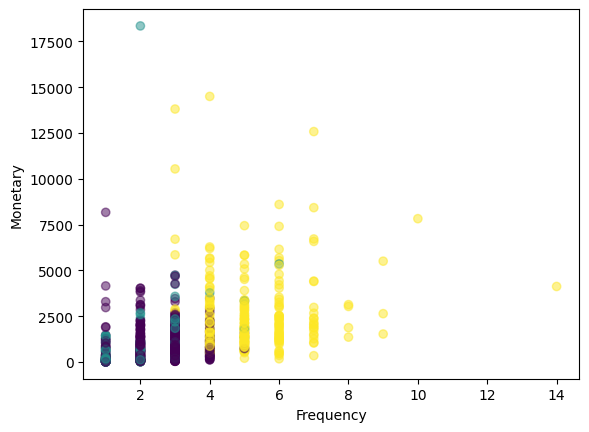

In [24]:
import matplotlib.pyplot as plt

plt.scatter(data=datamart, x='Frequency', y='Sales_Last_18_M', alpha=0.5, c=cluster_labels)
plt.xlabel('Frequency')
plt.ylabel('Monetary')
# plt.yscale('log')
# plt.xscale('log')
plt.show()